# UCI HAR - classification
- https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

#### 데이터 종류
- 561개 특성으로 전처리된 메인 데이터셋(X_train, X_test)
- Inertial Signals 데이터셋: 원시 센서 값(raw signal)

#### Inertial Signals 데이터 구조
- 각 파일은 행 = 샘플(segment), 열 = 시계열 프레임을 의미
- 각 샘플은 2.56초 길이 (샘플링 주파수 50Hz, 128 타임스텝 → 128 / 50 = 2.56초)
- 이미 샘플링이 되어 있으므로(7352개의 샘플) split_sequence() 사용하지 않아도 됨
- 한 행이 (128,) 길이의 시계열 벡터
- 세 축(X, Y, Z)와 센서 종류(acc, gyro)로 분리되어 있음

#### 센서 및 값의 의미
- Total acceleration (total_acc): 스마트폰 가속도계로 측정한 총 가속도 (중력 + 신체 움직임 포함)
- Body acceleration (body_acc): 총 가속도에서 중력 성분을 제거한 값 (실제 동작 가속도)
- Gyroscope (body_gyro): 각속도(회전 속도), 단위는 rad/sec, 스마트폰의 자이로스코프 센서 값

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [ ]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_data/UCI HAR Dataset/"

# Load "X"
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []  # 한 센서축 데이터 전체 저장

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("첫 번째 샘플 데이터:\n", X_train[0])


X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
첫 번째 샘플 데이터:
 [[ 1.808515e-04  1.076681e-02  5.556068e-02 ...  1.012817e+00
  -1.232167e-01  1.029341e-01]
 [ 1.013856e-02  6.579480e-03  5.512483e-02 ...  1.022833e+00
  -1.268756e-01  1.056872e-01]
 [ 9.275574e-03  8.928878e-03  4.840473e-02 ...  1.022028e+00
  -1.240037e-01  1.021025e-01]
 ...
 [-1.147484e-03  1.714439e-04  2.647864e-03 ...  1.018445e+00
  -1.240696e-01  1.003852e-01]
 [-2.222655e-04  1.574181e-03  2.381057e-03 ...  1.019372e+00
  -1.227451e-01  9.987355e-02]
 [ 1.575500e-03  3.070189e-03 -2.269757e-03 ...  1.021171e+00
  -1.213260e-01  9.498741e-02]]


In [ ]:
# Load "y"

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    # 라벨을 0부터 시작하도록 -1 (원래 라벨이 1부터 시)
    return np.array(labels, dtype=np.int32) - 1


y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train[:5])

y_train shape: (7352,)
y_test shape: (2947,)
[4 4 4 4 4]


- LSTM의 입력 (time_steps, n_features)
- 각 샘플은 길이 time steps 길이의 시계열, 각 시점마다 n_features 차원의 특징
- 128 -> 은닉, 셀 상태의 차원
- return_sequences=False 하면 마지막 은닉 상태만 반환 -> (batch, hidden_size)

## Model 1
- CNN 3, LSTM 1

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    LSTM(128, return_sequences=False, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,406 (1.31 MB)

 Trainable params: 341,510 (1.30 MB)

 Non-trainable params: 896 (3.50 KB)

None


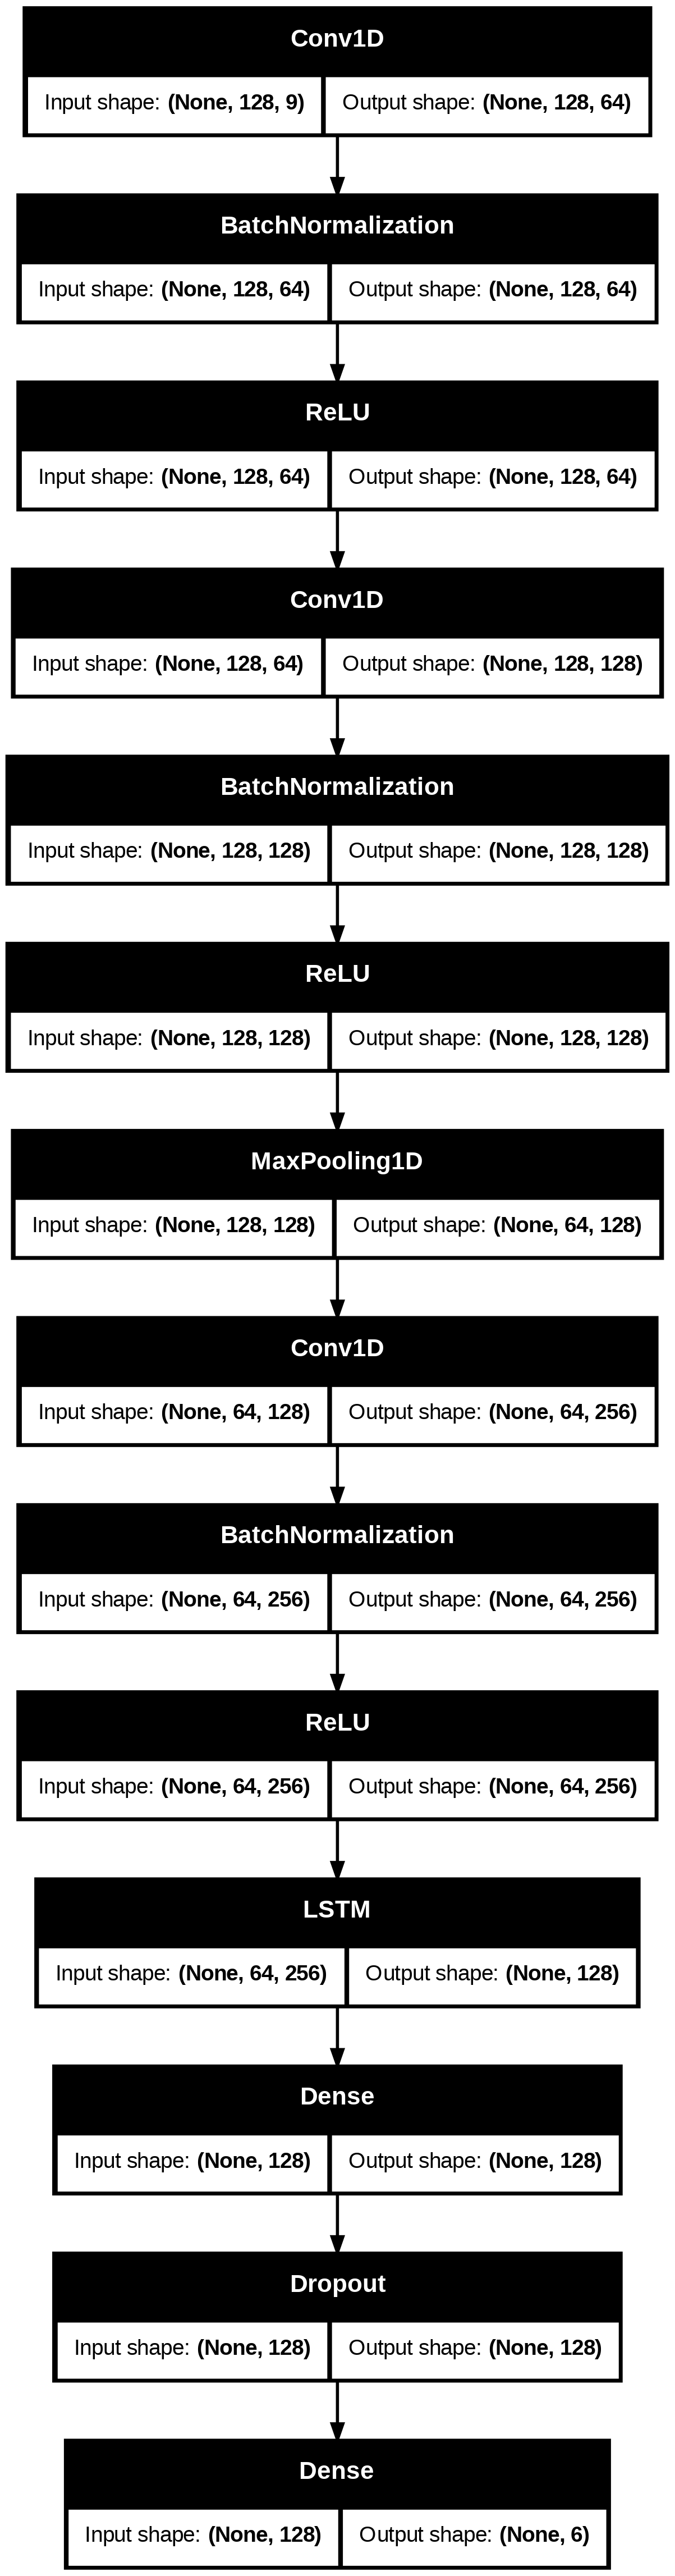

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_LSTM_best.h5",
                save_best_only=True,
                monitor="sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7139 - sparse_categorical_accuracy: 0.7135
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.83693, saving model to UCI_HAR_CNN_LSTM_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.7106 - sparse_categorical_accuracy: 0.7148 - val_loss: 4.2124 - val_sparse_categorical_accuracy: 0.2644
Epoch 2/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1529 - sparse_categorical_accuracy: 0.9429
Epoch 2: sparse_categorical_accuracy improved from 0.83693 to 0.94559, saving model to UCI_HAR_CNN_LSTM_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1525 - sparse_categorical_accuracy: 0.9430 - val_loss: 1.9847 - val_sparse_categorical_accuracy: 0.5357
Epoch 3/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.9436
Epoch 3: sparse_categorical_accuracy improved from 0.94559 to 0.94610, saving model to UCI_HAR_CNN_LSTM_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1440 - sparse_categorical_accuracy: 0.9437 - val_loss: 0.8578 - val_sparse_categorical_accuracy: 0.7512
Epoch 4/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1410 - sparse_categorical_accuracy: 0.9393
Epoch 4: sparse_categorical_accuracy improved from 0.94610 to 0.94763, saving model to UCI_HAR_CNN_LSTM_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1399 - sparse_categorical_accuracy: 0.9397 - val_loss: 0.2314 - val_sparse_categorical_accuracy: 0.9191
Epoch 5/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0957 - sparse_categorical_accuracy: 0.9579
Epoch 5: sparse_categorical_accuracy improved from 0.94763 to 0.95120, saving model to UCI_HAR_CNN_LSTM_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0959 - sparse_categorical_accuracy: 0.9578 - val_loss: 0.4691 - val_sparse_categorical_accuracy: 0.8572
Epoch 6/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1112 - sparse_categorical_accuracy: 0.9542
Epoch 6: sparse_categorical_accuracy did not improve from 0.95120
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.1113 - sparse_categorical_accuracy: 0.9540 - val_loss: 0.2489 - val_sparse_categorical_accuracy: 0.9123
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.9550
Epoch 7: sparse_categorical_accuracy improved from 0.95120 to 0.95698, saving model to UCI_HAR_CNN_LSTM_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.2218 - val_sparse_categorical_accuracy: 0.9341
Epoch 8/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0955 - sparse_categorical_accuracy: 0.9576
Epoch 8: sparse_categorical_accuracy improved from 0.95698 to 0.96004, saving model to UCI_HAR_CNN_LSTM_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0952 - sparse_categorical_accuracy: 0.9577 - val_loss: 0.2539 - val_sparse_categorical_accuracy: 0.9055
Epoch 9/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0958 - sparse_categorical_accuracy: 0.9555
Epoch 9: sparse_categorical_accuracy did not improve from 0.96004
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0957 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.3553 - val_sparse_categorical_accuracy: 0.9266
Epoch 10/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0877 - sparse_categorical_accuracy: 0.9607
Epoch 10: sparse_categorical_accuracy did not improve from 0.96004
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0878 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.3428 - val_sparse_categorical_accuracy: 0.9150
Epoch 11/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0975 - sparse_categorical_accuracy: 0.9625
Epoch 11: sparse_categorical_accuracy did not improve from 0.96004
92/92 ━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0855 - sparse_categorical_accuracy: 0.9587 - val_loss: 0.3198 - val_sparse_categorical_accuracy: 0.9286
Epoch 16/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0818 - sparse_categorical_accuracy: 0.9657
Epoch 16: sparse_categorical_accuracy did not improve from 0.96089
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.2981 - val_sparse_categorical_accuracy: 0.9137
Epoch 17/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9580
Epoch 17: sparse_categorical_accuracy did not improve from 0.96089
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.2782 - val_sparse_categorical_accuracy: 0.9157
Epoch 18/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0938 - sparse_categorical_accuracy: 0.9591
Epoch 18: sparse_categorical_accuracy did not improve from 0.96089
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0809 - sparse_categorical_accuracy: 0.9648 - val_loss: 0.3281 - val_sparse_categorical_accuracy: 0.9293
Epoch 27/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0857 - sparse_categorical_accuracy: 0.9585
Epoch 27: sparse_categorical_accuracy did not improve from 0.96225
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0856 - sparse_categorical_accuracy: 0.9585 - val_loss: 0.2804 - val_sparse_categorical_accuracy: 0.9327
Epoch 28/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0841 - sparse_categorical_accuracy: 0.9574
Epoch 28: sparse_categorical_accuracy did not improve from 0.96225
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0839 - sparse_categorical_accuracy: 0.9576 - val_loss: 0.2753 - val_sparse_categorical_accuracy: 0.9198
Epoch 29/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0947 - sparse_categorical_accuracy: 0.9561
Epoch 29: sparse_categorical_accuracy did not improve from 0.96225
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0774 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.2931 - val_sparse_categorical_accuracy: 0.9232
Epoch 31/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0811 - sparse_categorical_accuracy: 0.9616
Epoch 31: sparse_categorical_accuracy did not improve from 0.96259
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0813 - sparse_categorical_accuracy: 0.9616 - val_loss: 0.2833 - val_sparse_categorical_accuracy: 0.9211
Epoch 32/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0890 - sparse_categorical_accuracy: 0.9592
Epoch 32: sparse_categorical_accuracy did not improve from 0.96259
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0889 - sparse_categorical_accuracy: 0.9592 - val_loss: 0.3363 - val_sparse_categorical_accuracy: 0.9286
Epoch 33/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0780 - sparse_categorical_accuracy: 0.9648
Epoch 33: sparse_categorical_accuracy did not improve from 0.96259
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0805 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.3660 - val_sparse_categorical_accuracy: 0.9361
Epoch 35/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.9639
Epoch 35: sparse_categorical_accuracy improved from 0.96293 to 0.96310, saving model to UCI_HAR_CNN_LSTM_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0808 - sparse_categorical_accuracy: 0.9639 - val_loss: 0.3065 - val_sparse_categorical_accuracy: 0.9232
Epoch 36/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0721 - sparse_categorical_accuracy: 0.9659
Epoch 36: sparse_categorical_accuracy improved from 0.96310 to 0.96616, saving model to UCI_HAR_CNN_LSTM_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0721 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.3673 - val_sparse_categorical_accuracy: 0.9177
Epoch 37/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9620
Epoch 37: sparse_categorical_accuracy did not improve from 0.96616
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0818 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.3247 - val_sparse_categorical_accuracy: 0.9225
Epoch 38/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0864 - sparse_categorical_accuracy: 0.9592
Epoch 38: sparse_categorical_accuracy did not improve from 0.96616
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0863 - sparse_categorical_accuracy: 0.9592 - val_loss: 0.3521 - val_sparse_categorical_accuracy: 0.9293
Epoch 39/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0748 - sparse_categorical_accuracy: 0.9653
Epoch 39: sparse_categorical_accuracy did not improve from 0.96616
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0651 - sparse_categorical_accuracy: 0.9689 - val_loss: 0.2833 - val_sparse_categorical_accuracy: 0.9109
Epoch 43/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0769 - sparse_categorical_accuracy: 0.9619
Epoch 43: sparse_categorical_accuracy did not improve from 0.96803
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0770 - sparse_categorical_accuracy: 0.9619 - val_loss: 0.2864 - val_sparse_categorical_accuracy: 0.9123
Epoch 44/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0726 - sparse_categorical_accuracy: 0.9630
Epoch 44: sparse_categorical_accuracy did not improve from 0.96803
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0725 - sparse_categorical_accuracy: 0.9631 - val_loss: 0.3041 - val_sparse_categorical_accuracy: 0.9273
Epoch 45/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0708 - sparse_categorical_accuracy: 0.9635
Epoch 45: sparse_categorical_accuracy did not improve from 0.96803
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0583 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.3048 - val_sparse_categorical_accuracy: 0.9293
Epoch 49/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0701 - sparse_categorical_accuracy: 0.9693
Epoch 49: sparse_categorical_accuracy did not improve from 0.96939
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0704 - sparse_categorical_accuracy: 0.9690 - val_loss: 0.2452 - val_sparse_categorical_accuracy: 0.9402
Epoch 50/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9656
Epoch 50: sparse_categorical_accuracy did not improve from 0.96939
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0649 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.3098 - val_sparse_categorical_accuracy: 0.9259
Epoch 51/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0634 - sparse_categorical_accuracy: 0.9654
Epoch 51: sparse_categorical_accuracy did not improve from 0.96939
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0581 - sparse_categorical_accuracy: 0.9708 - val_loss: 0.3681 - val_sparse_categorical_accuracy: 0.9157
Epoch 64/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9632
Epoch 64: sparse_categorical_accuracy did not improve from 0.97126
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0675 - sparse_categorical_accuracy: 0.9633 - val_loss: 0.3825 - val_sparse_categorical_accuracy: 0.9279
Epoch 65/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0633 - sparse_categorical_accuracy: 0.9704
Epoch 65: sparse_categorical_accuracy did not improve from 0.97126
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0633 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.3941 - val_sparse_categorical_accuracy: 0.9116
Epoch 66/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0632 - sparse_categorical_accuracy: 0.9684
Epoch 66: sparse_categorical_accuracy did not improve from 0.97126
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0646 - sparse_categorical_accuracy: 0.9664 - val_loss: 0.4024 - val_sparse_categorical_accuracy: 0.9273
Epoch 69/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0573 - sparse_categorical_accuracy: 0.9722
Epoch 69: sparse_categorical_accuracy did not improve from 0.97177
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.3407 - val_sparse_categorical_accuracy: 0.9096
Epoch 70/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0649 - sparse_categorical_accuracy: 0.9661
Epoch 70: sparse_categorical_accuracy did not improve from 0.97177
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0646 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.3359 - val_sparse_categorical_accuracy: 0.9347
Epoch 71/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0631 - sparse_categorical_accuracy: 0.9693
Epoch 71: sparse_categorical_accuracy did not improve from 0.97177
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0634 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.3492 - val_sparse_categorical_accuracy: 0.9069
Epoch 73/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9754
Epoch 73: sparse_categorical_accuracy improved from 0.97262 to 0.97296, saving model to UCI_HAR_CNN_LSTM_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0514 - sparse_categorical_accuracy: 0.9754 - val_loss: 0.3203 - val_sparse_categorical_accuracy: 0.9361
Epoch 74/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0588 - sparse_categorical_accuracy: 0.9678
Epoch 74: sparse_categorical_accuracy did not improve from 0.97296
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9677 - val_loss: 0.3445 - val_sparse_categorical_accuracy: 0.9225
Epoch 75/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0585 - sparse_categorical_accuracy: 0.9711
Epoch 75: sparse_categorical_accuracy did not improve from 0.97296
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0585 - sparse_categorical_accuracy: 0.9711 - val_loss: 0.3521 - val_sparse_categorical_accuracy: 0.9211
Epoch 76/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9715
Epoch 76: sparse_categorical_accuracy did not improve from 0.97296
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0490 - sparse_categorical_accuracy: 0.9780 - val_loss: 0.4833 - val_sparse_categorical_accuracy: 0.9021
Epoch 80/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0543 - sparse_categorical_accuracy: 0.9748
Epoch 80: sparse_categorical_accuracy improved from 0.97432 to 0.97551, saving model to UCI_HAR_CNN_LSTM_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.3864 - val_sparse_categorical_accuracy: 0.9245
Epoch 81/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0499 - sparse_categorical_accuracy: 0.9752
Epoch 81: sparse_categorical_accuracy did not improve from 0.97551
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0500 - sparse_categorical_accuracy: 0.9751 - val_loss: 0.3847 - val_sparse_categorical_accuracy: 0.9320
Epoch 82/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0624 - sparse_categorical_accuracy: 0.9684
Epoch 82: sparse_categorical_accuracy did not improve from 0.97551
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0623 - sparse_categorical_accuracy: 0.9684 - val_loss: 0.3829 - val_sparse_categorical_accuracy: 0.9320
Epoch 83/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0609 - sparse_categorical_accuracy: 0.9696
Epoch 83: sparse_categorical_accuracy did not improve from 0.97551
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0433 - sparse_categorical_accuracy: 0.9769 - val_loss: 0.5494 - val_sparse_categorical_accuracy: 0.8987
Epoch 98/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0547 - sparse_categorical_accuracy: 0.9718
Epoch 98: sparse_categorical_accuracy did not improve from 0.97772
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9718 - val_loss: 0.5256 - val_sparse_categorical_accuracy: 0.9368
Epoch 99/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0413 - sparse_categorical_accuracy: 0.9789
Epoch 99: sparse_categorical_accuracy did not improve from 0.97772
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0414 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.3961 - val_sparse_categorical_accuracy: 0.9341
Epoch 100/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0609 - sparse_categorical_accuracy: 0.9711
Epoch 100: sparse_categorical_accuracy did not improve from 0.97772
92/92 ━━━━━━━━━━━

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("UCI_HAR_CNN_LSTM_best.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 95.24%
Training loss: 0.1545
Test accuracy: 91.31%
Test loss: 0.4720


model.predict
- 각 시퀀스 샘플마다, 모든 클래스에 대한 예측 확률 벡터
- y_pred_proba.shape -> (샘플 수, 클래스 수)

np.argmax
- 최대 값의 인덱스를 선택 = 라벨

In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9435    0.9710       496
           1     0.9372    0.9512    0.9442       471
           2     0.8968    0.9929    0.9424       420
           3     0.7979    0.7882    0.7930       491
           4     0.8444    0.8158    0.8298       532
           5     1.0000    1.0000    1.0000       537

    accuracy                         0.9131      2947
   macro avg     0.9127    0.9153    0.9134      2947
weighted avg     0.9135    0.9131    0.9128      2947



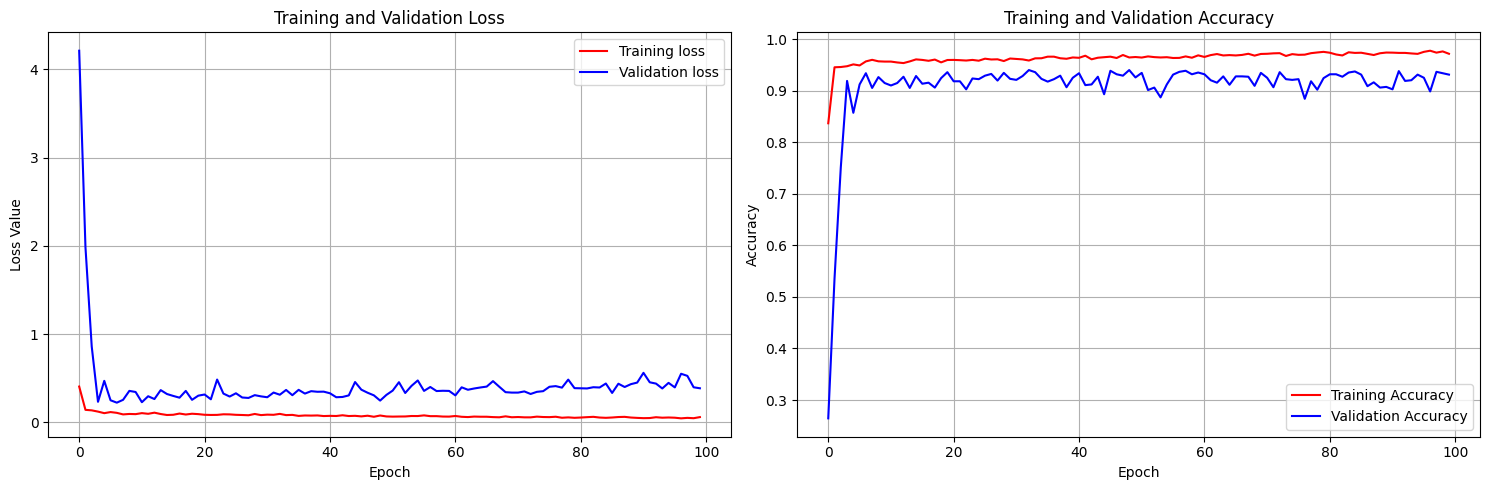

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

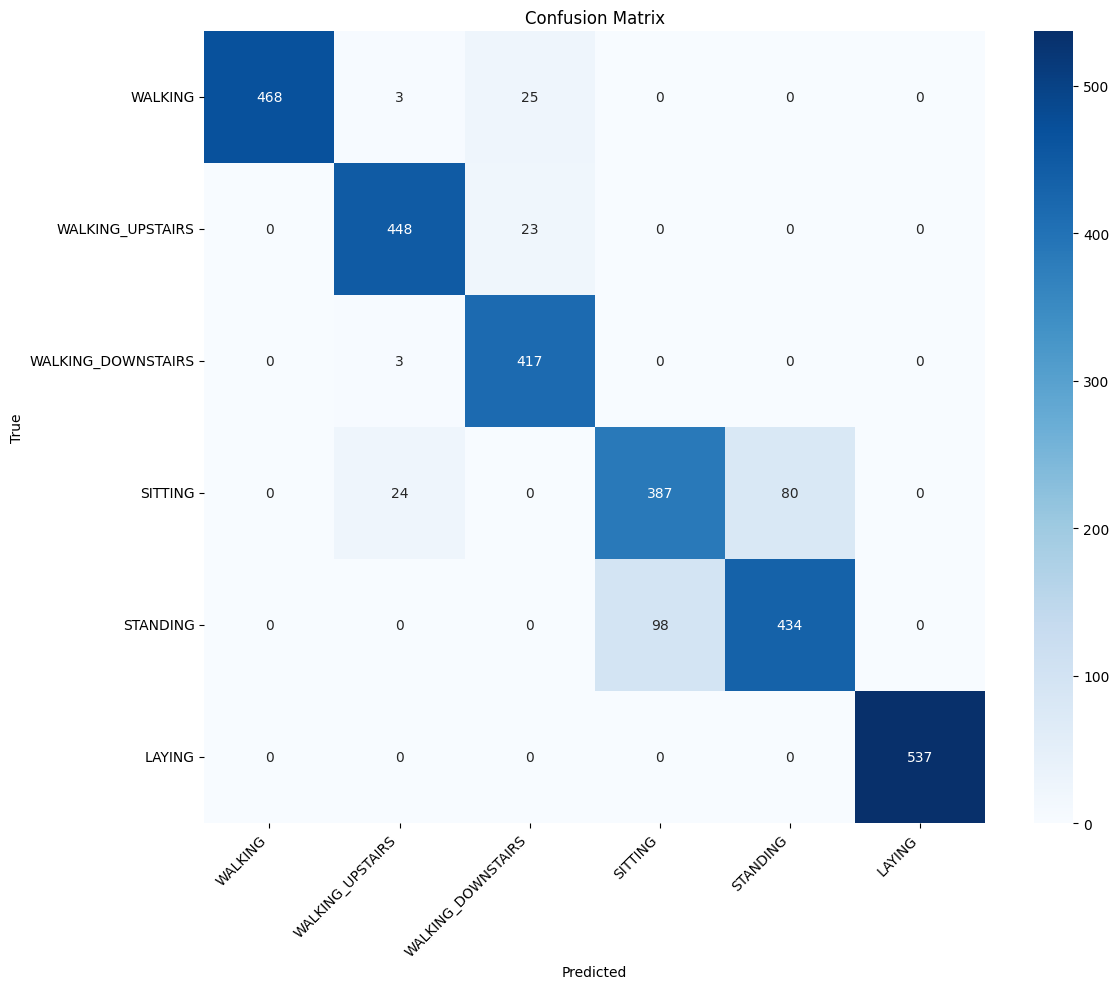

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- CNN 3, LSTM 2

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    LSTM(128, return_sequences=True, dropout=0.2),
    LSTM(128, return_sequences=False, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 128, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 128, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 473,990 (1.81 MB)

 Trainable params: 473,094 (1.80 MB)

 Non-trainable params: 896 (3.50 KB)

None


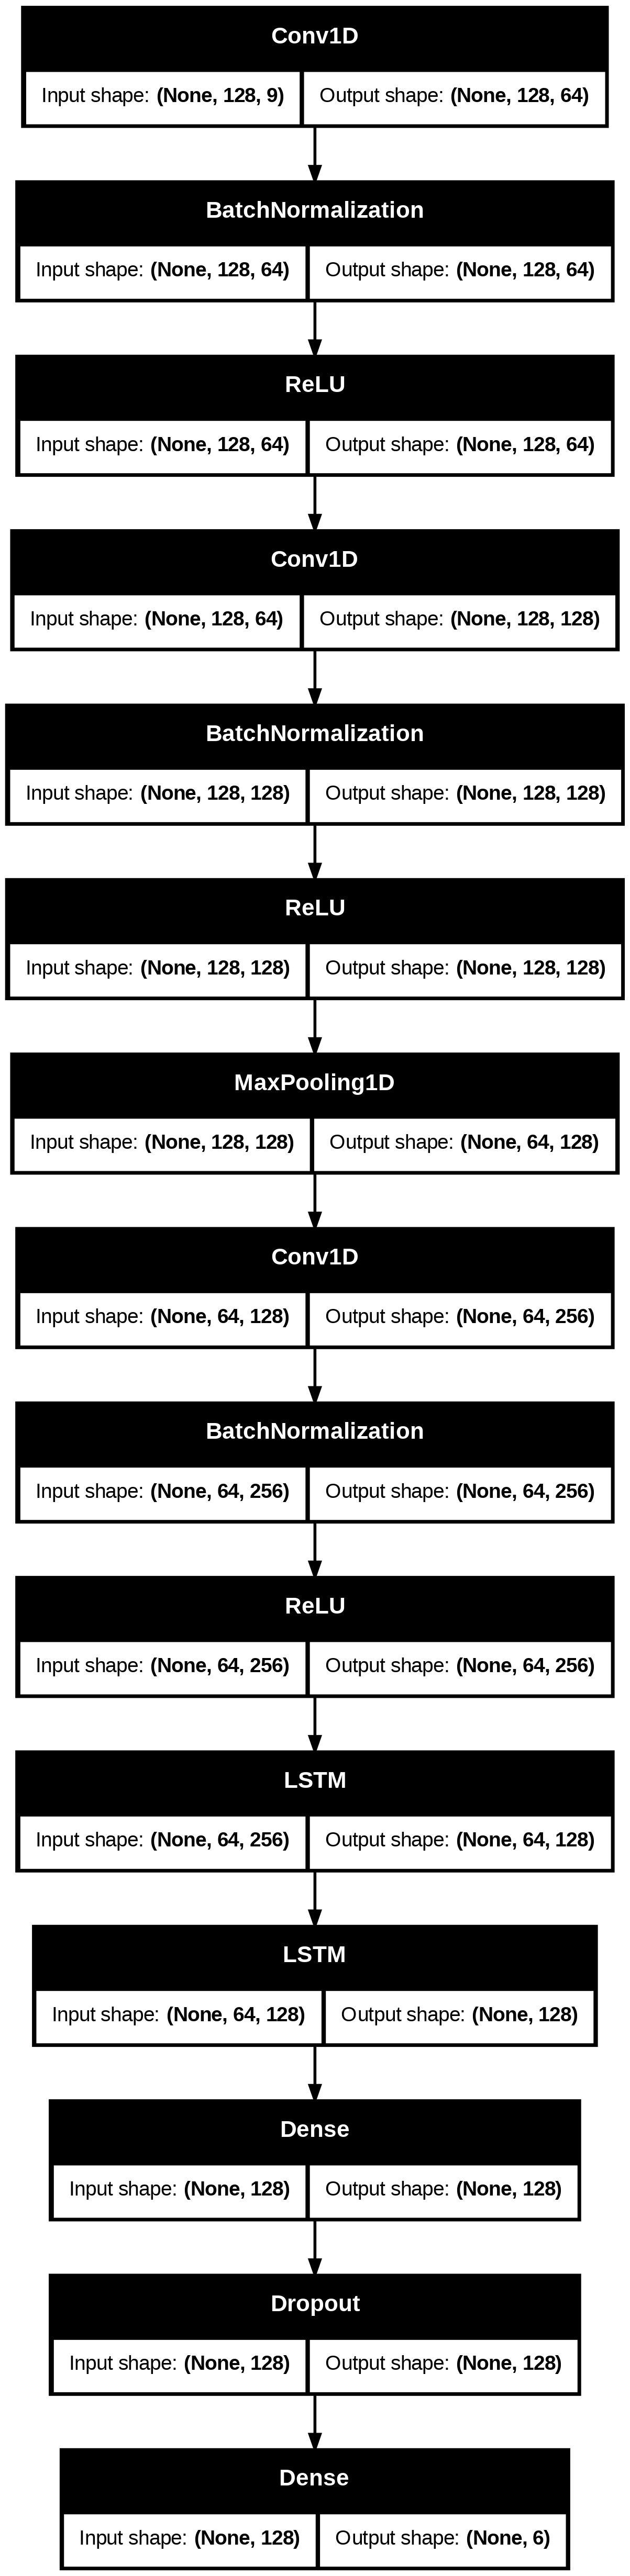

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_LSTM_best2.h5",
                save_best_only=True,
                monitor="sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7228 - sparse_categorical_accuracy: 0.7311
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.84747, saving model to UCI_HAR_CNN_LSTM_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7129 - sparse_categorical_accuracy: 0.7348 - val_loss: 4.4795 - val_sparse_categorical_accuracy: 0.2930
Epoch 2/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1588 - sparse_categorical_accuracy: 0.9423
Epoch 2: sparse_categorical_accuracy improved from 0.84747 to 0.94151, saving model to UCI_HAR_CNN_LSTM_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1584 - sparse_categorical_accuracy: 0.9423 - val_loss: 3.0646 - val_sparse_categorical_accuracy: 0.4473
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1437 - sparse_categorical_accuracy: 0.9452
Epoch 3: sparse_categorical_accuracy improved from 0.94151 to 0.94304, saving model to UCI_HAR_CNN_LSTM_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1438 - sparse_categorical_accuracy: 0.9452 - val_loss: 0.3739 - val_sparse_categorical_accuracy: 0.8844
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9466
Epoch 4: sparse_categorical_accuracy improved from 0.94304 to 0.95001, saving model to UCI_HAR_CNN_LSTM_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9467 - val_loss: 0.2752 - val_sparse_categorical_accuracy: 0.9130
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.9494
Epoch 5: sparse_categorical_accuracy did not improve from 0.95001
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.9493 - val_loss: 0.2824 - val_sparse_categorical_accuracy: 0.9021
Epoch 6/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1163 - sparse_categorical_accuracy: 0.9535
Epoch 6: sparse_categorical_accuracy improved from 0.95001 to 0.95732, saving model to UCI_HAR_CNN_LSTM_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1160 - sparse_categorical_accuracy: 0.9535 - val_loss: 0.2260 - val_sparse_categorical_accuracy: 0.9252
Epoch 7/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1127 - sparse_categorical_accuracy: 0.9521
Epoch 7: sparse_categorical_accuracy did not improve from 0.95732
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1131 - sparse_categorical_accuracy: 0.9520 - val_loss: 0.3430 - val_sparse_categorical_accuracy: 0.9062
Epoch 8/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1296 - sparse_categorical_accuracy: 0.9514
Epoch 8: sparse_categorical_accuracy did not improve from 0.95732
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1295 - sparse_categorical_accuracy: 0.9514 - val_loss: 0.3987 - val_sparse_categorical_accuracy: 0.8872
Epoch 9/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.9536
Epoch 9: sparse_categorical_accuracy did not improve from 0.95732
92/92 ━━━━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1005 - sparse_categorical_accuracy: 0.9526 - val_loss: 0.2581 - val_sparse_categorical_accuracy: 0.9307
Epoch 11/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1188 - sparse_categorical_accuracy: 0.9443
Epoch 11: sparse_categorical_accuracy did not improve from 0.95834
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1185 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.2490 - val_sparse_categorical_accuracy: 0.9361
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0996 - sparse_categorical_accuracy: 0.9551
Epoch 12: sparse_categorical_accuracy did not improve from 0.95834
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0995 - sparse_categorical_accuracy: 0.9551 - val_loss: 0.3069 - val_sparse_categorical_accuracy: 0.9205
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1214 - sparse_categorical_accuracy: 0.9520
Epoch 13: sparse_categorical_accuracy did not improve from 0.95834
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.9555 - val_loss: 0.2839 - val_sparse_categorical_accuracy: 0.9300
Epoch 15/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0942 - sparse_categorical_accuracy: 0.9575
Epoch 15: sparse_categorical_accuracy did not improve from 0.96004
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0944 - sparse_categorical_accuracy: 0.9574 - val_loss: 0.2768 - val_sparse_categorical_accuracy: 0.9218
Epoch 16/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0918 - sparse_categorical_accuracy: 0.9592
Epoch 16: sparse_categorical_accuracy did not improve from 0.96004
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0918 - sparse_categorical_accuracy: 0.9592 - val_loss: 0.3020 - val_sparse_categorical_accuracy: 0.9164
Epoch 17/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0893 - sparse_categorical_accuracy: 0.9586
Epoch 17: sparse_categorical_accuracy did not improve from 0.96004
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0834 - sparse_categorical_accuracy: 0.9585 - val_loss: 0.2143 - val_sparse_categorical_accuracy: 0.9184
Epoch 32/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0804 - sparse_categorical_accuracy: 0.9634
Epoch 32: sparse_categorical_accuracy did not improve from 0.96055
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.4293 - val_sparse_categorical_accuracy: 0.9069
Epoch 33/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0862 - sparse_categorical_accuracy: 0.9583
Epoch 33: sparse_categorical_accuracy did not improve from 0.96055
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0864 - sparse_categorical_accuracy: 0.9583 - val_loss: 0.2690 - val_sparse_categorical_accuracy: 0.8926
Epoch 34/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0812 - sparse_categorical_accuracy: 0.9633
Epoch 34: sparse_categorical_accuracy did not improve from 0.96055
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0824 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.3576 - val_sparse_categorical_accuracy: 0.9415
Epoch 36/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0776 - sparse_categorical_accuracy: 0.9613
Epoch 36: sparse_categorical_accuracy did not improve from 0.96259
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0778 - sparse_categorical_accuracy: 0.9613 - val_loss: 0.6283 - val_sparse_categorical_accuracy: 0.8933
Epoch 37/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0968 - sparse_categorical_accuracy: 0.9594
Epoch 37: sparse_categorical_accuracy did not improve from 0.96259
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0972 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.3937 - val_sparse_categorical_accuracy: 0.9361
Epoch 38/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1014 - sparse_categorical_accuracy: 0.9571
Epoch 38: sparse_categorical_accuracy did not improve from 0.96259
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0810 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.3596 - val_sparse_categorical_accuracy: 0.9293
Epoch 54/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0764 - sparse_categorical_accuracy: 0.9621
Epoch 54: sparse_categorical_accuracy improved from 0.96378 to 0.96429, saving model to UCI_HAR_CNN_LSTM_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0764 - sparse_categorical_accuracy: 0.9621 - val_loss: 0.2604 - val_sparse_categorical_accuracy: 0.9225
Epoch 55/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0868 - sparse_categorical_accuracy: 0.9624
Epoch 55: sparse_categorical_accuracy improved from 0.96429 to 0.96446, saving model to UCI_HAR_CNN_LSTM_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0866 - sparse_categorical_accuracy: 0.9624 - val_loss: 0.3330 - val_sparse_categorical_accuracy: 0.9395
Epoch 56/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0824 - sparse_categorical_accuracy: 0.9643
Epoch 56: sparse_categorical_accuracy did not improve from 0.96446
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0824 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.3239 - val_sparse_categorical_accuracy: 0.9300
Epoch 57/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0801 - sparse_categorical_accuracy: 0.9633
Epoch 57: sparse_categorical_accuracy did not improve from 0.96446
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0801 - sparse_categorical_accuracy: 0.9633 - val_loss: 0.3864 - val_sparse_categorical_accuracy: 0.9307
Epoch 58/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9622
Epoch 58: sparse_categorical_accuracy did not improve from 0.96446
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.3458 - val_sparse_categorical_accuracy: 0.9286
Epoch 70/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0814 - sparse_categorical_accuracy: 0.9606
Epoch 70: sparse_categorical_accuracy did not improve from 0.96582
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0814 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.3197 - val_sparse_categorical_accuracy: 0.9232
Epoch 71/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0842 - sparse_categorical_accuracy: 0.9624
Epoch 71: sparse_categorical_accuracy did not improve from 0.96582
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0842 - sparse_categorical_accuracy: 0.9624 - val_loss: 0.2457 - val_sparse_categorical_accuracy: 0.9157
Epoch 72/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0775 - sparse_categorical_accuracy: 0.9637
Epoch 72: sparse_categorical_accuracy did not improve from 0.96582
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0663 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.5243 - val_sparse_categorical_accuracy: 0.9184
Epoch 87/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9711
Epoch 87: sparse_categorical_accuracy improved from 0.96599 to 0.96684, saving model to UCI_HAR_CNN_LSTM_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0602 - sparse_categorical_accuracy: 0.9710 - val_loss: 0.3957 - val_sparse_categorical_accuracy: 0.9211
Epoch 88/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0732 - sparse_categorical_accuracy: 0.9630
Epoch 88: sparse_categorical_accuracy did not improve from 0.96684
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0733 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.3230 - val_sparse_categorical_accuracy: 0.8960
Epoch 89/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0831 - sparse_categorical_accuracy: 0.9617
Epoch 89: sparse_categorical_accuracy did not improve from 0.96684
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0832 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.3916 - val_sparse_categorical_accuracy: 0.9300
Epoch 90/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0751 - sparse_categorical_accuracy: 0.9672
Epoch 90: sparse_categorical_accuracy did not improve from 0.96684
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0699 - sparse_categorical_accuracy: 0.9641 - val_loss: 0.3371 - val_sparse_categorical_accuracy: 0.9273
Epoch 94/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0696 - sparse_categorical_accuracy: 0.9671
Epoch 94: sparse_categorical_accuracy improved from 0.96735 to 0.96905, saving model to UCI_HAR_CNN_LSTM_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0696 - sparse_categorical_accuracy: 0.9672 - val_loss: 0.4922 - val_sparse_categorical_accuracy: 0.9123
Epoch 95/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0643 - sparse_categorical_accuracy: 0.9708
Epoch 95: sparse_categorical_accuracy did not improve from 0.96905
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0645 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.3779 - val_sparse_categorical_accuracy: 0.9239
Epoch 96/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0651 - sparse_categorical_accuracy: 0.9675
Epoch 96: sparse_categorical_accuracy did not improve from 0.96905
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0652 - sparse_categorical_accuracy: 0.9675 - val_loss: 0.4443 - val_sparse_categorical_accuracy: 0.9007
Epoch 97/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9716
Epoch 97: sparse_categorical_accuracy did not improve from 0.96905
92/92 ━━━━━━━━━━━━━

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("UCI_HAR_CNN_LSTM_best2.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 96.03%
Training loss: 0.1419
Test accuracy: 92.16%
Test loss: 0.4702


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9519    0.9980    0.9744       496
           1     0.9867    0.9448    0.9653       471
           2     0.9469    0.9333    0.9400       420
           3     0.8243    0.8024    0.8132       491
           4     0.8297    0.8515    0.8404       532
           5     0.9981    1.0000    0.9991       537

    accuracy                         0.9216      2947
   macro avg     0.9229    0.9217    0.9221      2947
weighted avg     0.9218    0.9216    0.9215      2947



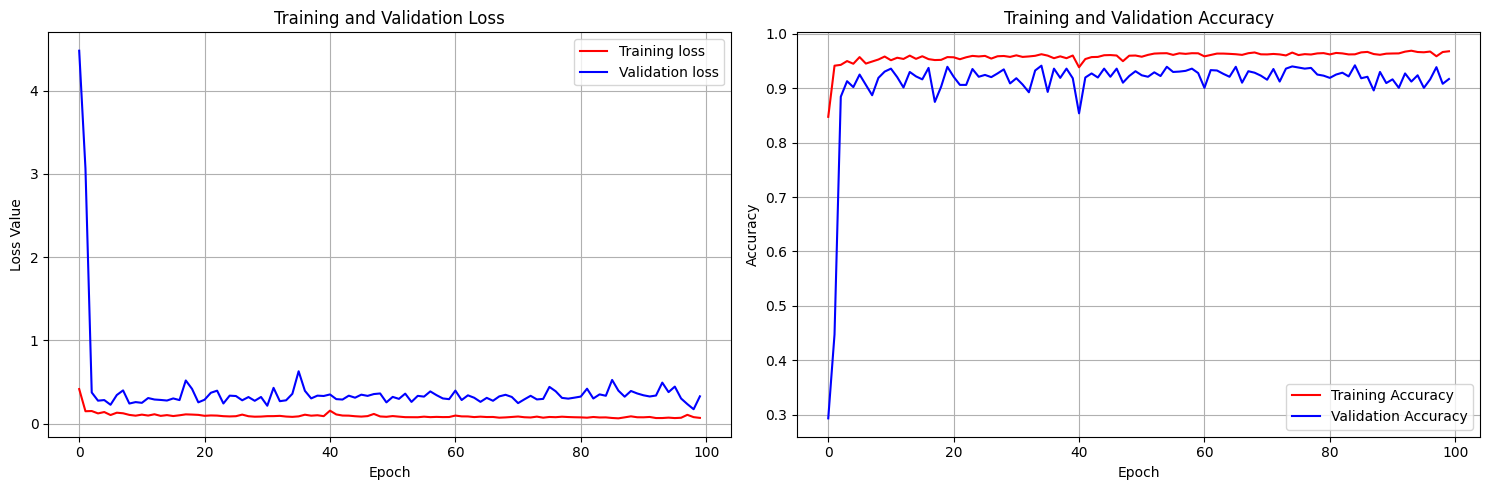

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

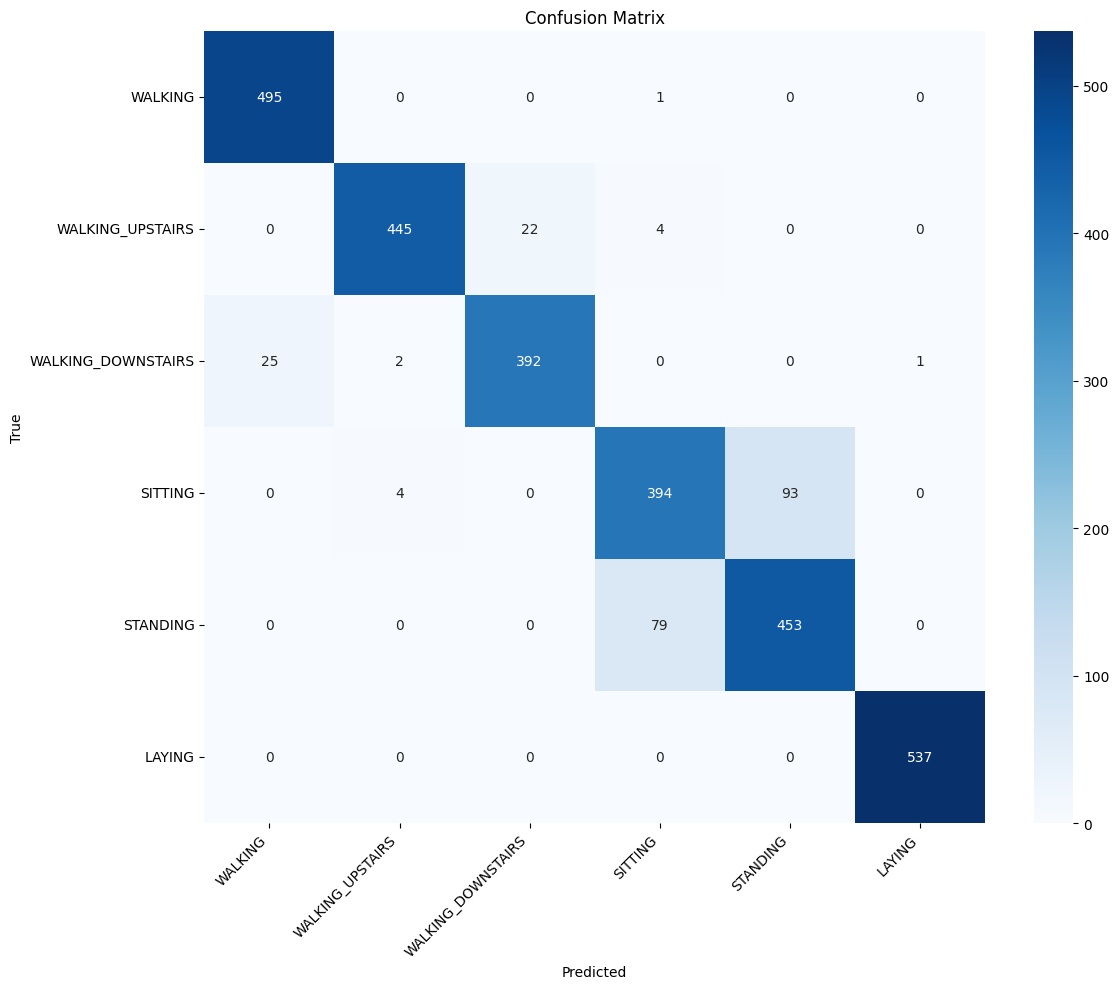

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()